In [1142]:
import pandas as pd
import numpy as np 
import  matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from scipy.stats import uniform, randint



In [1143]:
df = pd.read_csv("diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [1153]:
df.info() 
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    float64
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    float64
 8   Outcome                   768 non-null    float64
dtypes: float64(8), int64(1)
memory usage: 54.1 KB


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,1.695477,10.945129,72.386719,3.293387,4.152040,5.665243,0.365317,3.481574,0.348958
std,0.985735,1.364856,12.096642,0.321351,0.844576,0.596992,0.198510,0.313364,0.476951
min,0.000000,6.633250,24.000000,2.079442,2.708050,4.266146,0.075107,3.091042,0.000000
25%,1.000000,9.987469,64.000000,3.178054,3.449988,5.244044,0.218131,3.218876,0.000000
50%,1.732051,10.816654,72.000000,3.178054,3.473248,5.656854,0.316633,3.401197,0.000000
75%,2.449490,11.842705,80.000000,3.496508,4.853976,6.049793,0.486277,3.737670,1.000000
max,4.123106,14.106736,122.000000,4.605170,6.741701,8.191459,1.229641,4.406719,1.000000


In [1154]:
df.shape
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [1155]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [1156]:
df['Outcome'].value_counts()

Outcome
0.0    500
1.0    268
Name: count, dtype: int64

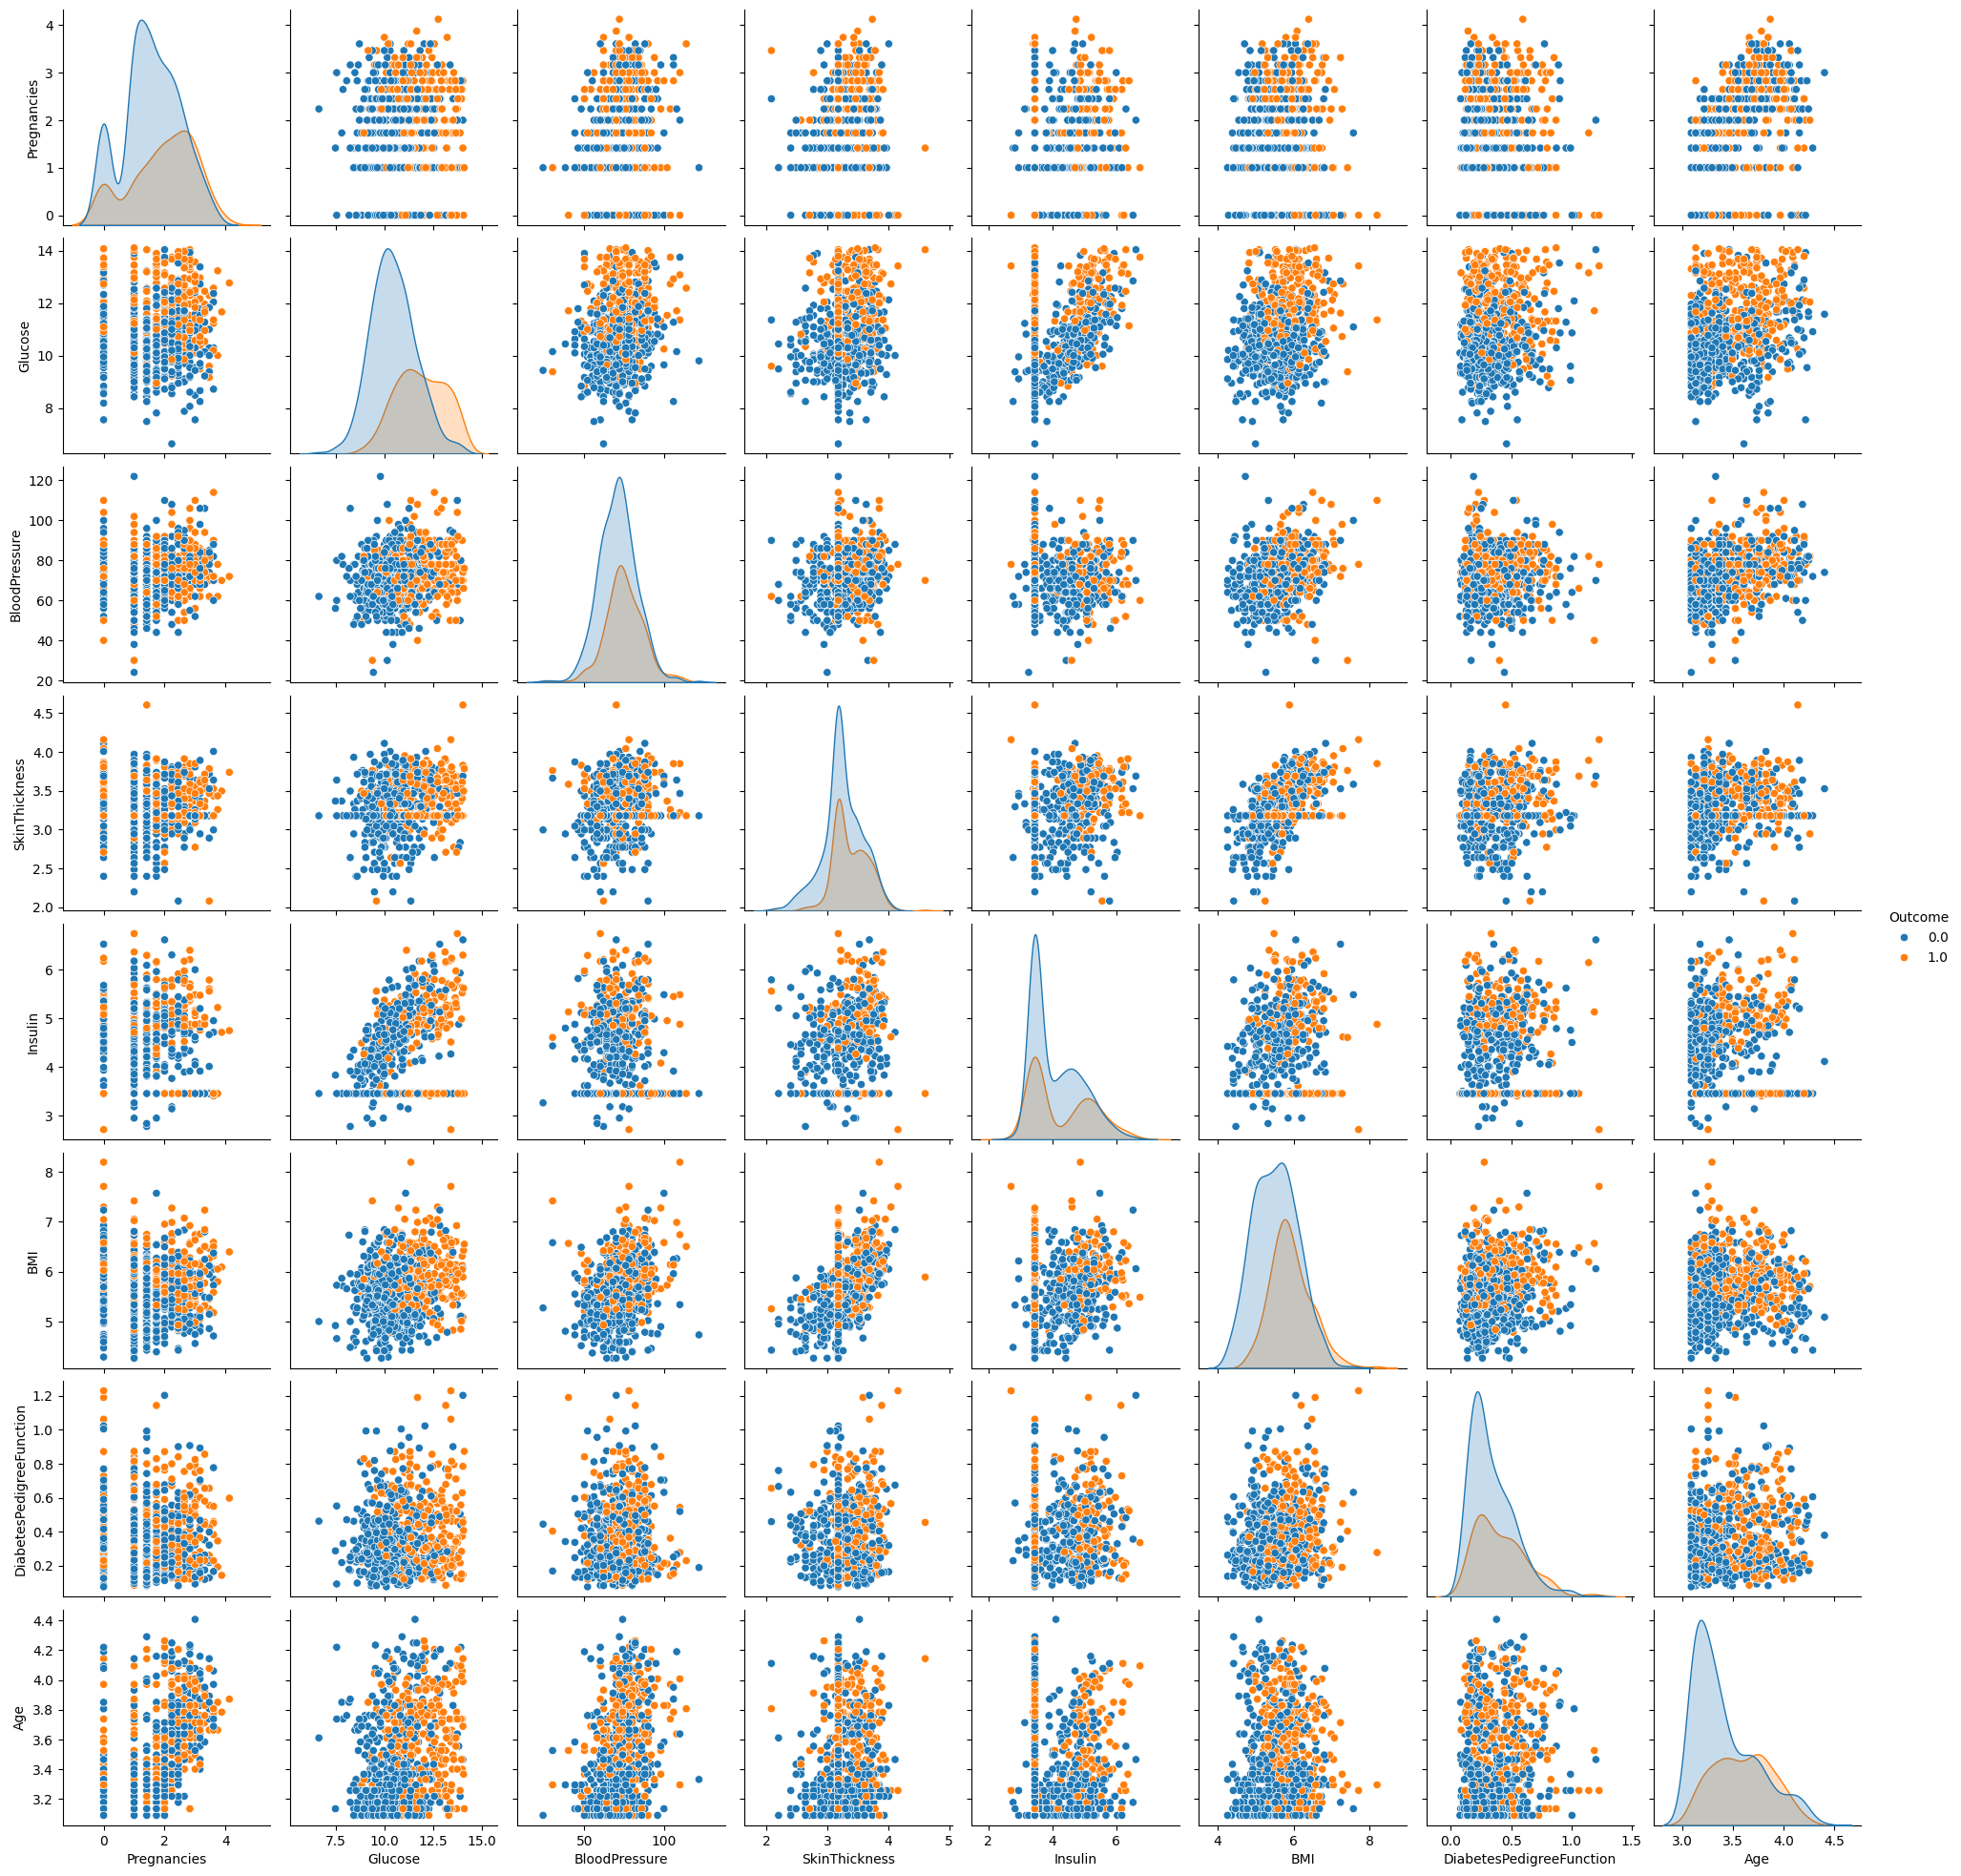

In [1157]:
sns.pairplot(data=df, hue='Outcome')

<Axes: >

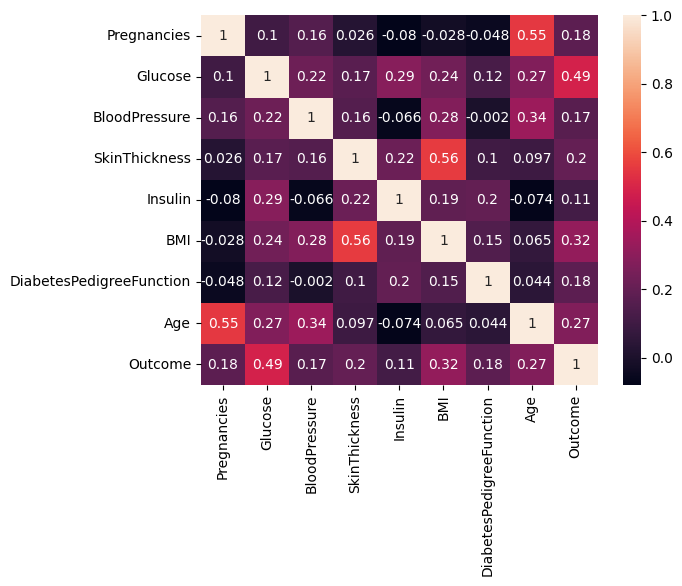

In [1158]:
sns.heatmap(df.corr(), annot=True)

In [1144]:
cols_to_replace = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Replace zeros with median 
for col in cols_to_replace:
   df[col] = df[col].replace(0, df[col].median())

print(df[cols_to_replace].describe())


          Glucose  BloodPressure  SkinThickness     Insulin         BMI
count  768.000000     768.000000     768.000000  768.000000  768.000000
mean   121.656250      72.386719      27.334635   94.652344   32.450911
std     30.438286      12.096642       9.229014  105.547598    6.875366
min     44.000000      24.000000       7.000000   14.000000   18.200000
25%     99.750000      64.000000      23.000000   30.500000   27.500000
50%    117.000000      72.000000      23.000000   31.250000   32.000000
75%    140.250000      80.000000      32.000000  127.250000   36.600000
max    199.000000     122.000000      99.000000  846.000000   67.100000


In [1145]:
# Check skewness
skewness = df.skew()
print(skewness)


Pregnancies                 0.901674
Glucose                     0.535587
BloodPressure               0.141885
SkinThickness               1.223057
Insulin                     2.693181
BMI                         0.601059
DiabetesPedigreeFunction    1.919911
Age                         1.129597
Outcome                     0.635017
dtype: float64


In [1146]:
#  apply transformations based on skewness
def fix_skewness(df):
    for col in df.columns:
        if df[col].skew() > 1: 
            df[col] = np.log1p(df[col])  
        elif df[col].skew() > 0.5:  
            df[col] = np.sqrt(df[col])  
    return df

df_transformed = fix_skewness(df)

print(df_transformed.skew())


Pregnancies                -0.158938
Glucose                     0.253892
BloodPressure               0.141885
SkinThickness              -0.227098
Insulin                     0.762239
BMI                         0.257673
DiabetesPedigreeFunction    1.117942
Age                         0.614664
Outcome                     0.635017
dtype: float64


In [1147]:
#remove outliers using IQR
def remove_outliers_iqr(df):
    Q1 = df.quantile(0.25)  
    Q3 = df.quantile(0.75)  
    IQR = Q3 - Q1           

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_cleaned = df[~((df < lower_bound) | (df > upper_bound)).any(axis=1)]
    
    return df_cleaned

df_final = remove_outliers_iqr(df_transformed)

print(f"Dataset shape after fixing skewness & removing outliers: {df_final.shape}")


Dataset shape after fixing skewness & removing outliers: (700, 9)


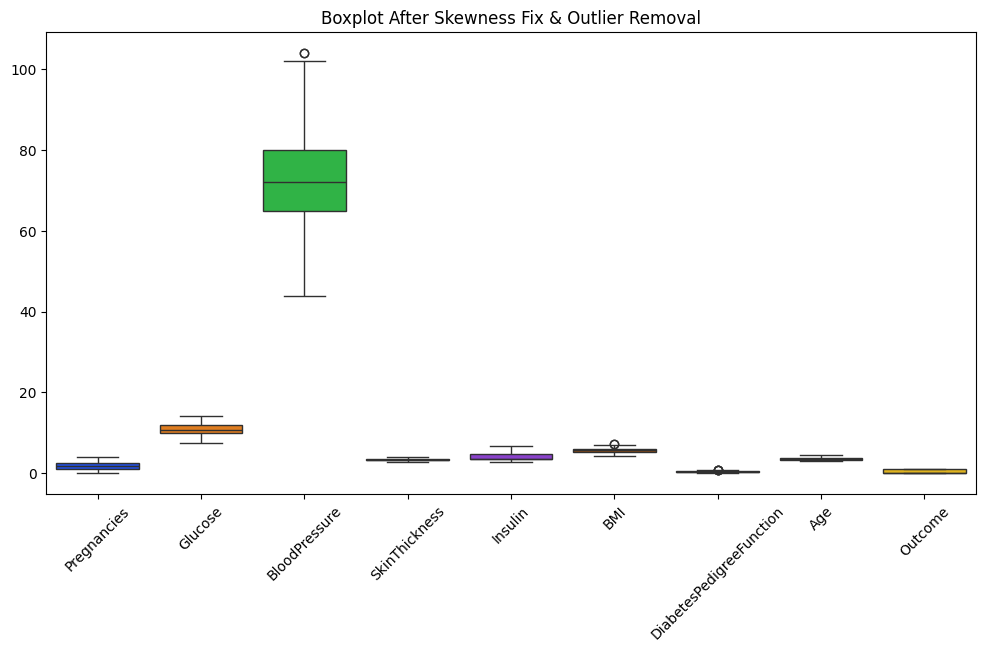

In [1148]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_final, palette='bright')
plt.xticks(rotation=45)
plt.title("Boxplot After Skewness Fix & Outlier Removal")
plt.show()


In [1149]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Split data
X = df_final.drop(columns=['Outcome'])  
y = df_final['Outcome'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize models
models = {
    "SVM": SVC(kernel='rbf', C=1.0),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression()
}




In [1151]:
from scipy.stats import uniform, randint

param_grids = {
    "SVM": {
        "C": uniform(0.1, 10),  
        "kernel": ["linear", "rbf", "poly", "sigmoid"],
        "gamma": ["scale", "auto"]
    },
    
    "Random Forest": {
        "n_estimators": randint(50, 300),
        "max_depth": randint(2, 20),
        "min_samples_split": randint(2, 10),
        "min_samples_leaf": randint(1, 10)
    },
    "Logistic Regression": {
        "C": uniform(0.1, 10),
        "solver": ["liblinear", "lbfgs", "saga"]
    }
}

# Train models with RandomizedSearchCV
best_models = {}
for name, model in models.items():
    print(f" Tuning {name}...")
    search = RandomizedSearchCV(model, param_distributions=param_grids[name], 
                                n_iter=20, cv=5, scoring="accuracy", random_state=42, n_jobs=-1)
    search.fit(X_train, y_train)
    
    best_models[name] = search.best_estimator_
    print(f" Best {name} Model: {search.best_params_}")
    
    # Evaluate the tuned model
    y_pred = search.best_estimator_.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f" Tuned {name} Accuracy: {acc:.4f}\n")



 Tuning SVM...
 Best SVM Model: {'C': np.float64(0.6808361216819946), 'gamma': 'auto', 'kernel': 'linear'}
 Tuned SVM Accuracy: 0.8214

 Tuning Random Forest...
 Best Random Forest Model: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 99}
 Tuned Random Forest Accuracy: 0.7643

 Tuning Logistic Regression...
 Best Logistic Regression Model: {'C': np.float64(0.30584494295802445), 'solver': 'lbfgs'}
 Tuned Logistic Regression Accuracy: 0.8214



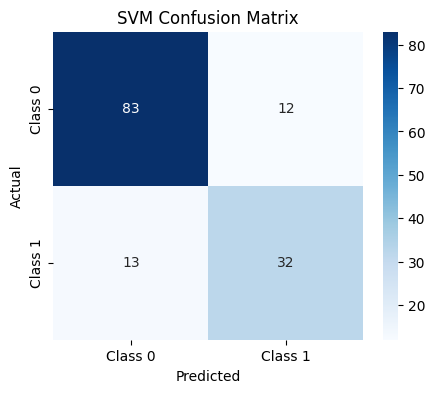

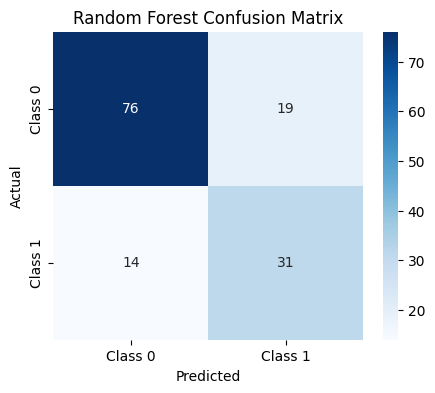

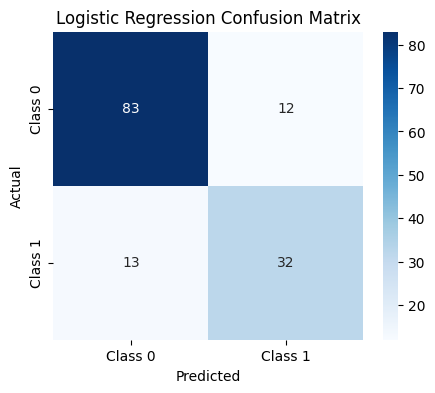

In [1162]:
from sklearn.metrics import confusion_matrix

for name, model in best_models.items():
    # Predict using the best model
    y_pred = model.predict(X_test)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{name} Confusion Matrix")
    plt.show()


In [1163]:
from sklearn.metrics import classification_report
import pickle

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    
    # Classification Report
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred))
    
    # Save the model
    with open(f"{name.replace(' ', '_')}_best_model.pkl", "wb") as f:
        pickle.dump(model, f)
    
    # Making Predictions on Test Data 
    sample_pred = model.predict(X_test[:5])  
    print(f"Sample Predictions for {name}: {sample_pred}\n")


Classification Report for SVM:
              precision    recall  f1-score   support

         0.0       0.86      0.87      0.87        95
         1.0       0.73      0.71      0.72        45

    accuracy                           0.82       140
   macro avg       0.80      0.79      0.79       140
weighted avg       0.82      0.82      0.82       140

Sample Predictions for SVM: [1. 0. 0. 1. 0.]

Classification Report for Random Forest:
              precision    recall  f1-score   support

         0.0       0.84      0.80      0.82        95
         1.0       0.62      0.69      0.65        45

    accuracy                           0.76       140
   macro avg       0.73      0.74      0.74       140
weighted avg       0.77      0.76      0.77       140

Sample Predictions for Random Forest: [1. 0. 0. 1. 0.]

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

         0.0       0.86      0.87      0.87        95
         1.0    